CORD-19 veri setindeki makale özetleri üzerinden bir mini arama motoru kurmayı amaçlıyoruz.
Kullanıcı bir anahtar kelime girecek ve en alakalı özetler sıralanacak.

TF-IDF Skoru = TF * IDF

TF (Term Frequency): Kelimenin bir belgede kaç kez geçtiğidir.

IDF (Inverse Document Frequency): O kelimenin kaç farklı belgede geçtiğidir. Çok yaygın kelimelere düşük puan verir.

Bu sayede:

“COVID”, “patients”, “treatment” gibi konuyla ilgili ama ayırt edici kelimeler öne çıkar.

“the”, “and” gibi herkesin kullandığı sıradan kelimeler baskılanır.


In [1]:
#Kütüphaneleri yükleme
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("/kaggle/input/CORD-19-research-challenge/metadata.csv")
df = df[["title", "abstract", "publish_time"]].dropna()
df["publish_time"] = pd.to_datetime(df["publish_time"], errors='coerce')
df = df.dropna(subset=["publish_time"])
df = df.reset_index(drop=True)

In [3]:

# Özetlerin ilk 5000 tanesiyle çalışalım (hızlı olması için)
df = df.head(5000)

In [4]:
df["abstract_clean"] = df["abstract"].astype(str).str.lower().str.replace(r'\W', ' ', regex=True)
df["title_clean"] = df["title"].astype(str).str.lower().str.replace(r'\W', ' ', regex=True)
#temizlik(boşlukları temizle)

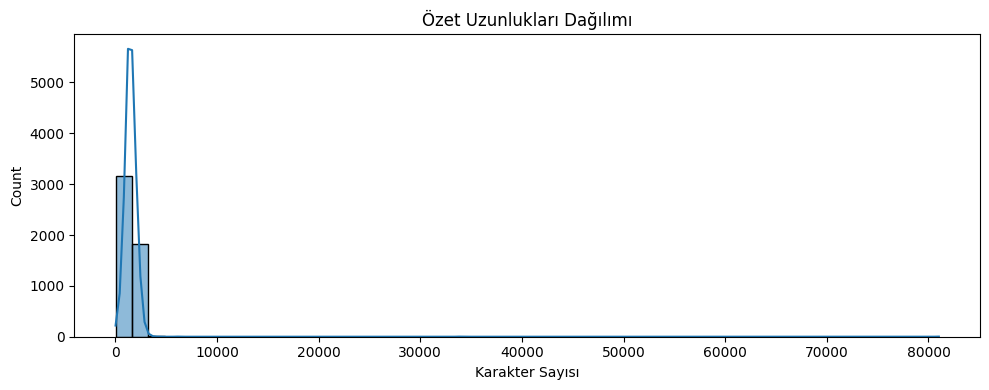

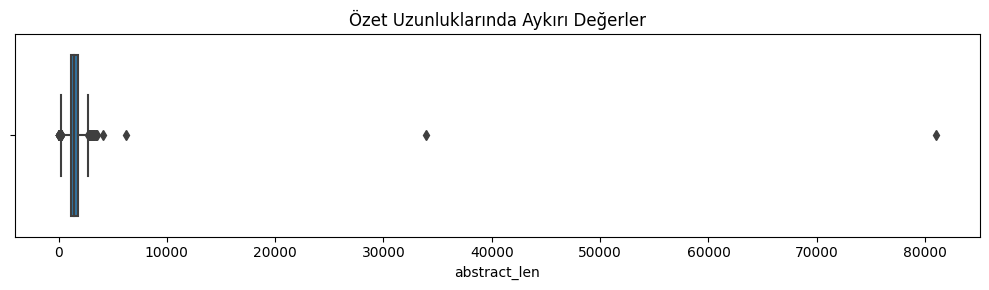

In [5]:
#özet uzunlukların dağılımı ve aykırılar
df["abstract_len"] = df["abstract_clean"].astype(str).apply(len)

plt.figure(figsize=(10,4))
sns.histplot(df["abstract_len"], bins=50, kde=True)
plt.title("Özet Uzunlukları Dağılımı")
plt.xlabel("Karakter Sayısı")
plt.tight_layout()
plt.show()

# Boxplot ile outlier
plt.figure(figsize=(10,3))
sns.boxplot(x=df["abstract_len"])
plt.title("Özet Uzunluklarında Aykırı Değerler")
plt.tight_layout()
plt.show()

TF-IDF OLUŞTURMA

Arama motorunda sadece title ve abstract sütunlarını kullanılacak. 

TF-IDF skoru abstract alanında hesaplanacak

In [6]:
#IQR yöntemi ile outlier bulma
Q1 = df["abstract_len"].quantile(0.25)
Q3 = df["abstract_len"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"Aykırı değer sınırları: {int(lower_bound)} - {int(upper_bound)} karakter")

Aykırı değer sınırları: 208 - 2760 karakter


In [7]:
#IQR yöntemi ile özet uzunluğu outlier silme
df_no_outlier = df[(df["abstract_len"] >= lower_bound) & (df["abstract_len"] <= upper_bound)].copy()


In [8]:
combined_text = df_no_outlier["title_clean"] + " " + df_no_outlier["abstract_clean"]

tfidf = TfidfVectorizer(stop_words="english", max_df=0.8)
tfidf_matrix = tfidf.fit_transform(combined_text)

In [9]:
#Arama fonksiyonu
def search(query, year_min=None, year_max=None, top_n=10):
    query = query.lower()
    query_vec = tfidf.transform([query])
    similarity = cosine_similarity(query_vec, tfidf_matrix).flatten()

    df_no_outlier["score"] = similarity
    df_filtered = df_no_outlier.copy()

    # Yayın yılına göre filtreleme
    if year_min:
        df_filtered = df_filtered[df_filtered["publish_time"].dt.year >= year_min]
    if year_max:
        df_filtered = df_filtered[df_filtered["publish_time"].dt.year <= year_max]

    df_filtered = df_filtered.sort_values("score", ascending=False).head(top_n)
    df_filtered["score"] = df_filtered["score"].round(4)

    return df_filtered[["publish_time", "title", "score", "abstract"]]

In [10]:
#örnek arama
# Sorgu örneği
results = search("vaccine immune response", year_min=2020, year_max=2021, top_n=5)

# Göster
for i, row in results.iterrows():
    print(f"\n📌 {row['title']} ({row['publish_time'].date()}) - Skor: {row['score']}")
    print(f"🔎 {row['abstract'][:300]}...\n")


📌 Immunoinformatics and Vaccine Development: An Overview (2020-02-26) - Skor: 0.3128
🔎 The use of vaccines have resulted in a remarkable improvement in global health. It has saved several lives, reduced treatment costs and raised the quality of animal and human lives. Current traditional vaccines came empirically with either vague or completely no knowledge of how they modulate our im...


📌 Imaging of tumour response to immunotherapy (2020-01-03) - Skor: 0.2088
🔎 A wide range of cancer immunotherapy approaches has been developed including non-specific immune-stimulants such as cytokines, cancer vaccines, immune checkpoint inhibitors (ICIs), and adoptive T cell therapy. Among them, ICIs are the most commonly used and intensively studied. Since 2011, these dru...


📌 Immune predictors of oral poliovirus vaccine immunogenicity among infants in South India (2020-03-23) - Skor: 0.2072
🔎 Identification of the causes of poor oral vaccine immunogenicity in low-income countries might lead to 

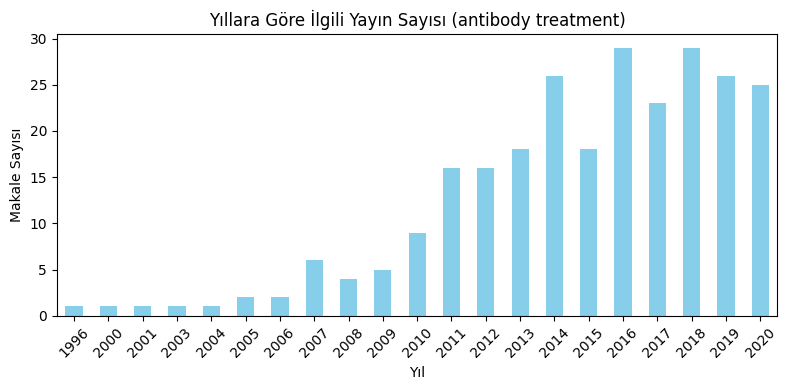

In [11]:
#Arama sonuçlarının yıllara göre dağılımı 
def plot_result_distribution(query):
    query_vec = tfidf.transform([query])
    similarity = cosine_similarity(query_vec, tfidf_matrix).flatten()
    
    df_temp = df_no_outlier.copy()
    df_temp["score"] = similarity
    df_temp["year"] = df_temp["publish_time"].dt.year
    df_temp = df_temp[df_temp["score"] > 0.05]
    
    year_counts = df_temp.groupby("year")["score"].count()
    
    plt.figure(figsize=(8,4))
    year_counts.plot(kind="bar", color="skyblue")
    plt.title(f"Yıllara Göre İlgili Yayın Sayısı ({query})")
    plt.xlabel("Yıl")
    plt.ylabel("Makale Sayısı")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Kullanım:
plot_result_distribution("antibody treatment")